# Sigma clip and stitch TESS light curves together.

In [1]:
%matplotlib inline

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt\

import lightcurvestuff as lcs
import starspot as ss
from starspot import rotation_tools as rt
import starspot.stitch as sps
import re
import glob

Load TESS light curve

In [46]:
fn = glob.glob("/Users/rangus/projects/TESSlightcurves/*fits")

def extract_ticid(fn): 
    numbers = re.findall(r'\d+', fn)
    return int(numbers[2]), int(numbers[1])

ticid, sector = extract_ticid(fn[0])

ticid = 149107360
ticid = 294274438

path = "/Users/rangus/projects/TESSlightcurves/"
str_ticid = str(int(ticid)).zfill(16)
tfile = "tess?????????????-s????-{}-????-s_lc.fits".format(str_ticid)

ticpath = os.path.join(path, tfile)
fnames = sorted(glob.glob(ticpath))

sectors = []
for f in fnames:
    _, sector = extract_ticid(f)
    sectors.append(sector)
    
time, flux, flux_err = lcs.tools.load_and_split_TESS(fnames)
nsectors = len(flux)
print(sectors, nsectors)

[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13] 12


Sigma clip each sector individually.

In [47]:
from tqdm import trange

def sigma_clip_TESS_sector(x, y, yerr):
    x, y, yerr = np.array(x), np.array(y), np.array(yerr)
    
    # Initial removal of extreme outliers.
    m = rt.sigma_clip(y, nsigma=7)
    x, y, yerr = x[m], y[m], yerr[m]

    # Remove outliers using Sav-Gol filter
    smooth, mask = rt.filter_sigma_clip(x, y)
    resids = y - smooth
    stdev = np.std(resids)
    return x[mask], y[mask], yerr[mask], stdev


x, y, yerr, std = [], [], [], []
for i in trange(len(time)):
    t, f, ferr, stdev = sigma_clip_TESS_sector(time[i], flux[i], flux_err[i])
    x.append(t)
    y.append(f)
    yerr.append(ferr)
    std.append(stdev)
    
print(std)
print(np.median(yerr[0]))

  0%|          | 0/12 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
100%|██████████| 12/12 [00:03<00:00,  3.88it/s]

[6.113177577302172, 5.727820454658104, 5.914725062240189, 6.026524428722342, 5.32130518850773, 5.282013721797511, 4.428110793949715, 4.290097736516864, 4.968733493726425, 5.492669474106738, 5.976974959533116, 6.160136623722616]
6.726286


12


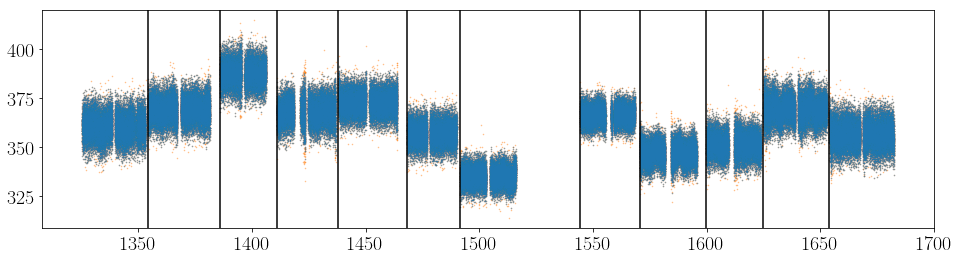

In [48]:
plt.figure(figsize=(16, 4))

start_times, stop_times = [], []
for i in range(len(time)):
    plt.plot(time[i], flux[i], "C1.", ms=1, alpha=.5)
    plt.plot(x[i], y[i], "C0.", ms=1, alpha=.5)
    start_times.append(min(time[i]))
    stop_times.append(max(flux[i]))
print(len(y))
    
gaps = start_times[1:]
for i in range(len(gaps)):
    plt.axvline(gaps[i], color="k")

Format light curve

In [49]:
original_flux_median = np.median(y[0])
y -= original_flux_median

# Meds
meds = []
for i in range(len(y)):
    meds.append(np.median(y[i]))
steps = meds[1:]
    
# Turn into arrays
t = np.array([i for j in x for i in j], dtype="float64")
y = np.array([i for j in y for i in j], dtype="float64")
yerr = np.array([i for j in yerr for i in j], dtype="float64")

# Remove NaNs
m = np.isfinite(t) * np.isfinite(y) * np.isfinite(yerr)
t, y, yerr = t[m], y[m], yerr[m]

# Subsample
subsample = 10
t, y, yerr = t[::subsample], y[::subsample], yerr[::subsample]

# Sort by time
inds = np.argsort(t)
t, y, yerr = t[inds], y[inds], yerr[inds]
gaps -= t[0]
t -= t[0]

[ 28.81379415  60.65290687  85.6074369  112.69684324 142.9779916
 166.33804336 219.08823611 245.22548306 274.55555427 299.6647706
 328.62532914]


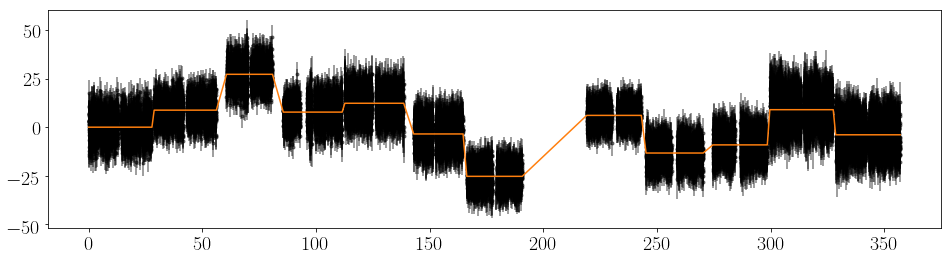

In [50]:
print(gaps)

plt.figure(figsize=(16, 4))
plt.errorbar(t, y, yerr=yerr, fmt="k.", alpha=.5)

from starspot.stitch import step_model

mu = step_model(t, gaps, meds[1:])
plt.plot(t, mu, "C1", zorder=10)

Find the offsets.

In [51]:
import starspot.stitch as sps

gap_times, steps = gaps, meds[1:]
star = sps.StitchModel(t, y, yerr, gap_times, steps, 2.0)
star.model_offsets()
map_soln = star.find_optimum()

step1 = map_soln["step1"]
step2 = map_soln["step2"]

success: False
initial logp: -138039.74684789483
final logp: -130523.3722273464


In [55]:
test_t = np.linspace(0, max(t), 1000)
mu, var = sps.evaluate_model(test_t)
plt.plot(t, y, ".")
plt.plot(test_t, mu)

AttributeError: module 'starspot.stitch' has no attribute 'evaluate_model'

In [52]:
# The step model
best_fit_mu = step_model(t, gap_times, steps)
corrected_y = y - best_fit_mu

# Median normalize
corrected_y /= original_flux_median

<ErrorbarContainer object of 3 artists>

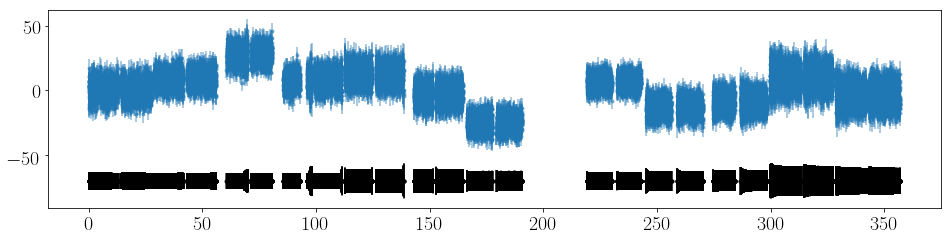

In [53]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.errorbar(t, y, yerr=yerr, fmt=".", alpha=.5)
plt.errorbar(t, corrected_y-70, yerr=yerr, fmt="k.", alpha=.5)

/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
100%|██████████| 1000/1000 [00:06<00:00, 157.77it/s]


0.05211685133893605


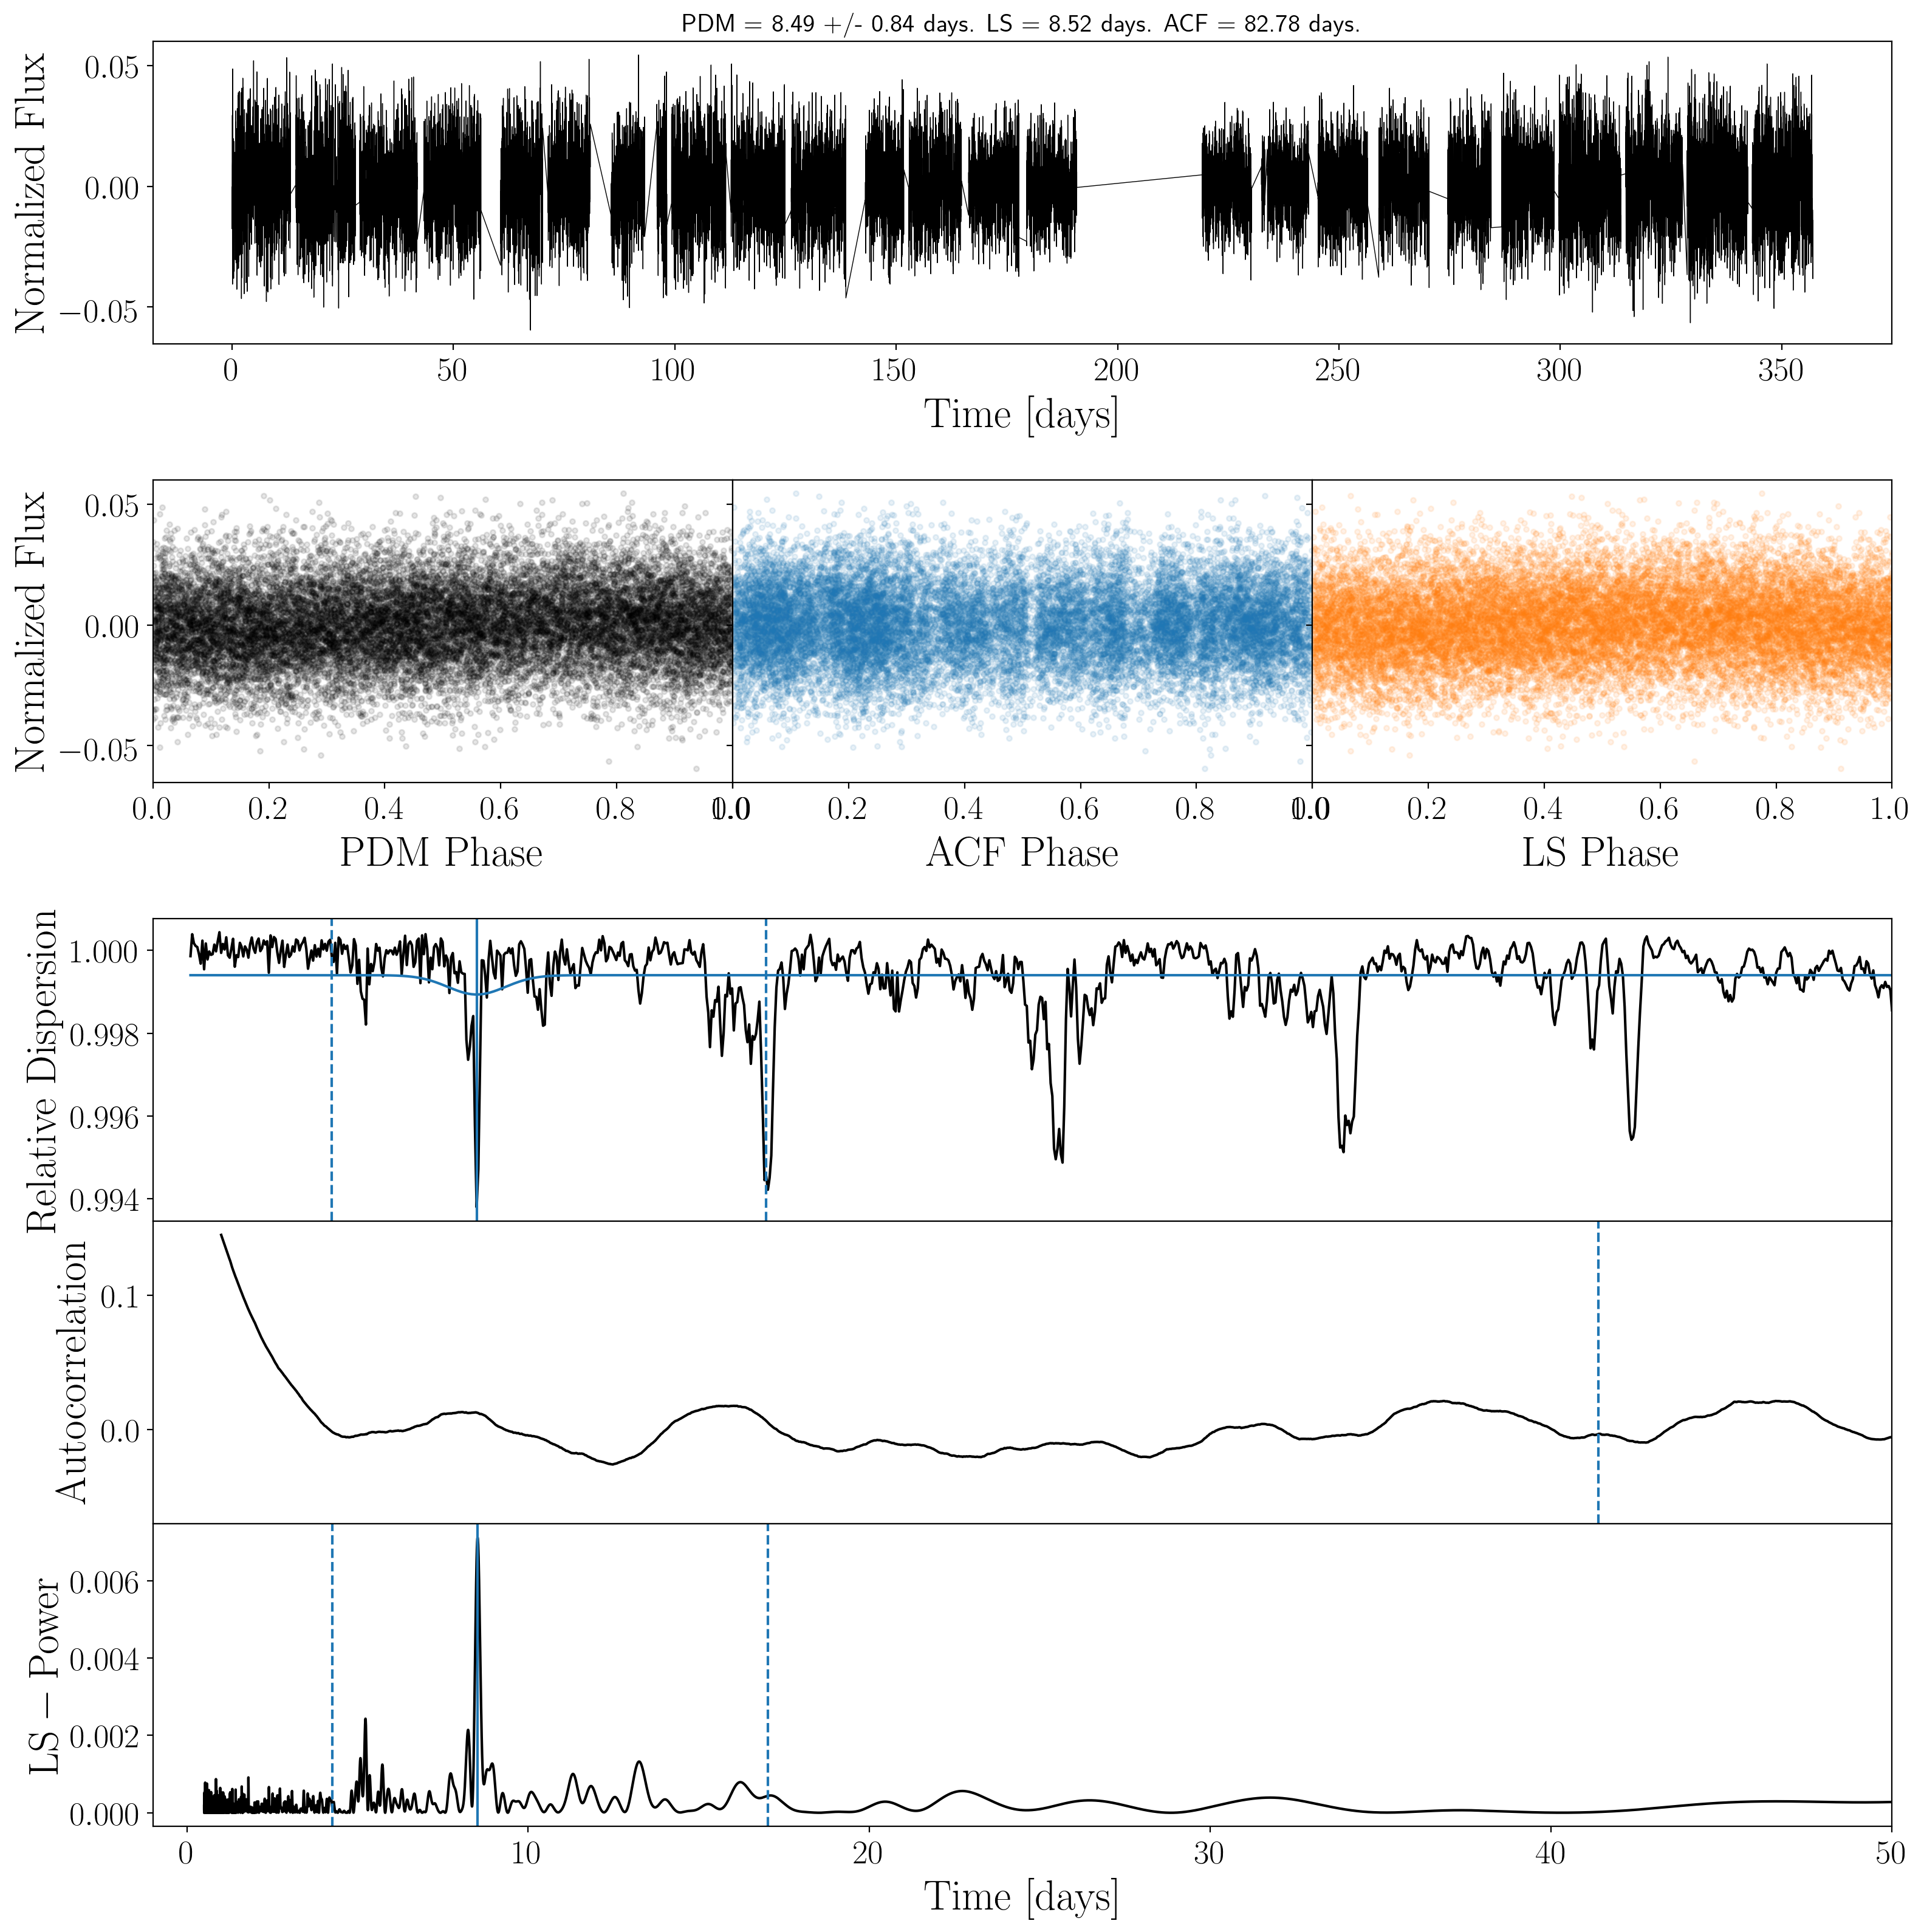

In [54]:
rotate = ss.RotationModel(t, corrected_y, yerr)
ls_period = rotate.ls_rotation()
acf_period = rotate.acf_rotation(interval=0.00138889, cutoff=1, window_length=999, polyorder=3)
period_grid = np.linspace(.1, 50, 1000)
pdm_period = rotate.pdm_rotation(period_grid)
fig = rotate.big_plot(methods=["pdm", "acf", "ls"], xlim=(-1, 50));
print(rotate.Rvar)